In [1]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# OpenWeatherMap API credentials
API_KEY = ""
LAT = "33.6995"  
LON = "73.0363" 
START_DATE = "2020-01-01"
END_DATE = "2024-02-01"

In [8]:
def fetch_pollution_data(lat, lon, start_date, end_date, api_key):
    url = "http://api.openweathermap.org/data/2.5/air_pollution/history"
    data = []
    current_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")

    while current_date <= end_date:
        timestamp = int(current_date.timestamp())
        response = requests.get(url, params={
            "lat": lat,
            "lon": lon,
            "start": timestamp,
            "end": timestamp + 86400,  # Fetch one day's data
            "appid": api_key
        })
        if response.status_code == 200:
            data.extend(response.json().get("list", []))
        else:
            print(f"Error: {response.status_code}, {response.text}")
        current_date += timedelta(days=1)

    return data

In [ ]:
# Fetch data
pollution_data = fetch_pollution_data(LAT, LON, START_DATE, END_DATE, API_KEY)

Data saved to pollution_data.csv


In [17]:
# Process and save data
df = pd.json_normalize(pollution_data)
df['dt'] = pd.to_datetime(df['dt'], unit='s')
df.columns = ['date', 'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']
df

,date,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,5,1895.90,8.38,47.98,0.30,6.38,75.65,88.42,7.79
1,2020-11-25 02:00:00,5,2323.15,23.69,47.30,0.03,8.11,86.31,100.36,8.49
2,2020-11-25 03:00:00,5,2803.80,45.15,51.41,0.08,10.01,87.22,100.78,8.23
3,2020-11-25 04:00:00,5,2510.07,26.38,67.17,1.41,13.83,65.45,75.37,6.71
4,2020-11-25 05:00:00,5,2803.80,32.63,66.49,2.44,16.93,66.46,77.39,7.98
...,...,...,...,...,...,...,...,...,...,...
27964,2024-01-01 15:00:00,5,6408.69,89.41,143.95,0.00,24.08,417.66,473.91,54.72
27965,2024-01-01 16:00:00,5,6782.53,95.67,150.80,0.00,28.85,446.78,508.85,66.88
27966,2024-01-01 17:00:00,5,7156.37,100.14,156.28,0.00,32.42,462.18,529.60,76.00
27967,2024-01-01 18:00:00,5,7049.56,98.35,157.65,0.00,32.42,455.77,523.89,77.01


In [27]:
df.to_csv('pollution_data.csv', index=False)

## Read Data

In [2]:
df = pd.read_csv('pollution_data.csv')

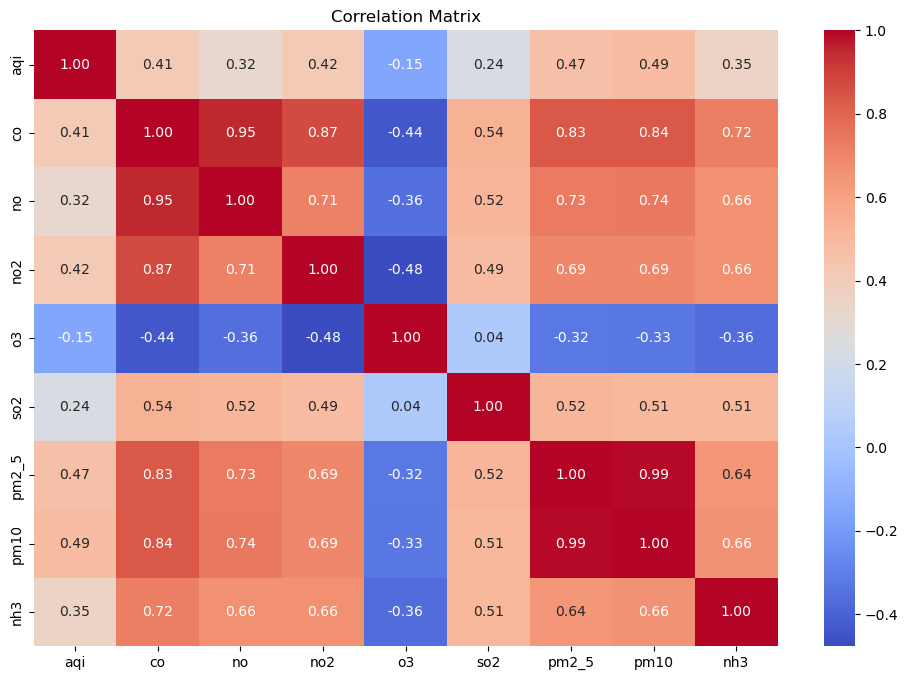

In [3]:
testing = df.drop(columns=['date'])

## Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(testing.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import numpy as np

In [4]:

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']])

In [5]:
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

SEQ_LENGTH = 50
X, y = create_sequences(data_scaled[:, 0], SEQ_LENGTH)

# Train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# List all available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    print(f"Available GPUs: {gpus}")
else:
    print("No GPUs found.")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [8]:
model = Sequential([
    LSTM(64, input_shape=(SEQ_LENGTH, 1), return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

I0000 00:00:1733945729.509916  417683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5582 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6
/home/neutrino/miniconda3/envs/mlops/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1733945739.035585  417991 cuda_dnn.cc:529] Loaded cuDNN version 90300


698/698 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - loss: 0.0582 - mae: 0.1421 - val_loss: 0.0111 - val_mae: 0.0607
Epoch 2/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0087 - mae: 0.0546 - val_loss: 0.0094 - val_mae: 0.0510
Epoch 3/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0081 - mae: 0.0479 - val_loss: 0.0095 - val_mae: 0.0573
Epoch 4/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0079 - mae: 0.0471 - val_loss: 0.0093 - val_mae: 0.0468
Epoch 5/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0079 - mae: 0.0452 - val_loss: 0.0094 - val_mae: 0.0505
Epoch 6/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - loss: 0.0078 - mae: 0.0459 - val_loss: 0.0092 - val_mae: 0.0476
Epoch 7/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.0080 - mae: 0.0462 - val_loss: 0.0093 - val_mae: 0.0538
Epoch 8/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0077 - mae: 0.0466 - val_loss: 0.0094 - val_mae: 0.0575
Epoch 9/10
698/698 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/st

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Mean Squared Error: 0.009566764678948528
Root Mean Squared Error: 0.09780983937696927


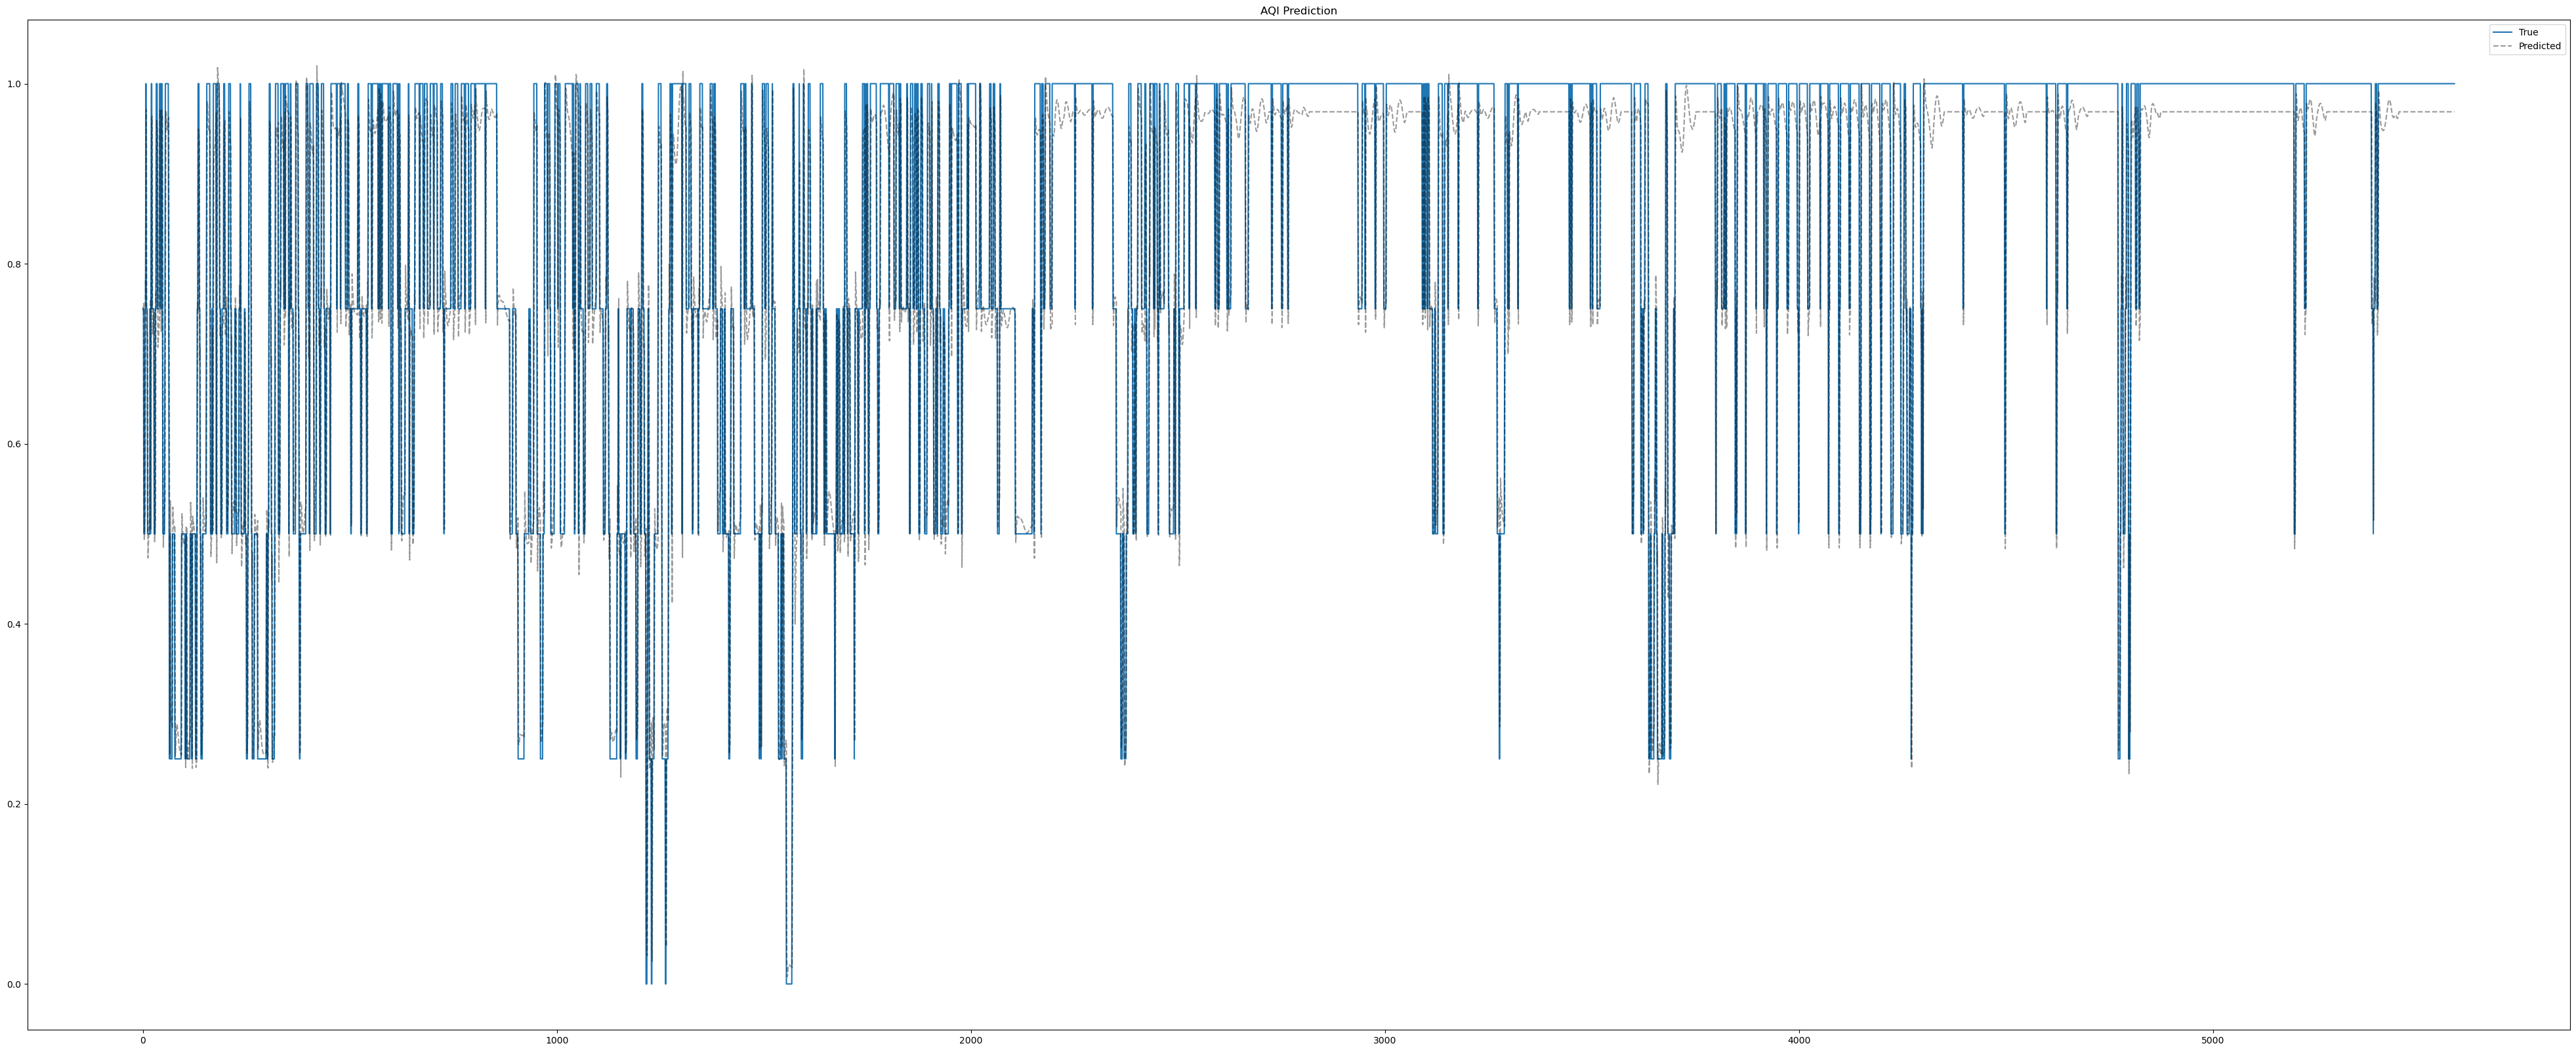

In [22]:
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {np.sqrt(mse)}")

plt.figure(figsize=(50, 20))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted', color='black', alpha=0.4, linestyle='dashed')
plt.title("AQI Prediction")
plt.legend()
plt.show()

In [2]:
import joblib

loaded_model = joblib.load("../model.pkl")


2024-12-12 04:25:27.211619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733959527.349478  468707 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733959527.393184  468707 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 04:25:27.814710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1733959535.195275  468707 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 55

In [4]:
import os 

features_path = '../data/features'
train_path = os.path.join(features_path, 'train.pkl')
test_path = os.path.join(features_path, 'test.pkl')

X_train, y_train = joblib.load(train_path)
X_test, y_test = joblib.load(test_path)

In [7]:
y_pred = loaded_model.predict(X_test)

175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


RMSE: 0.09777408897926264
MSE: 0.009559772475724768


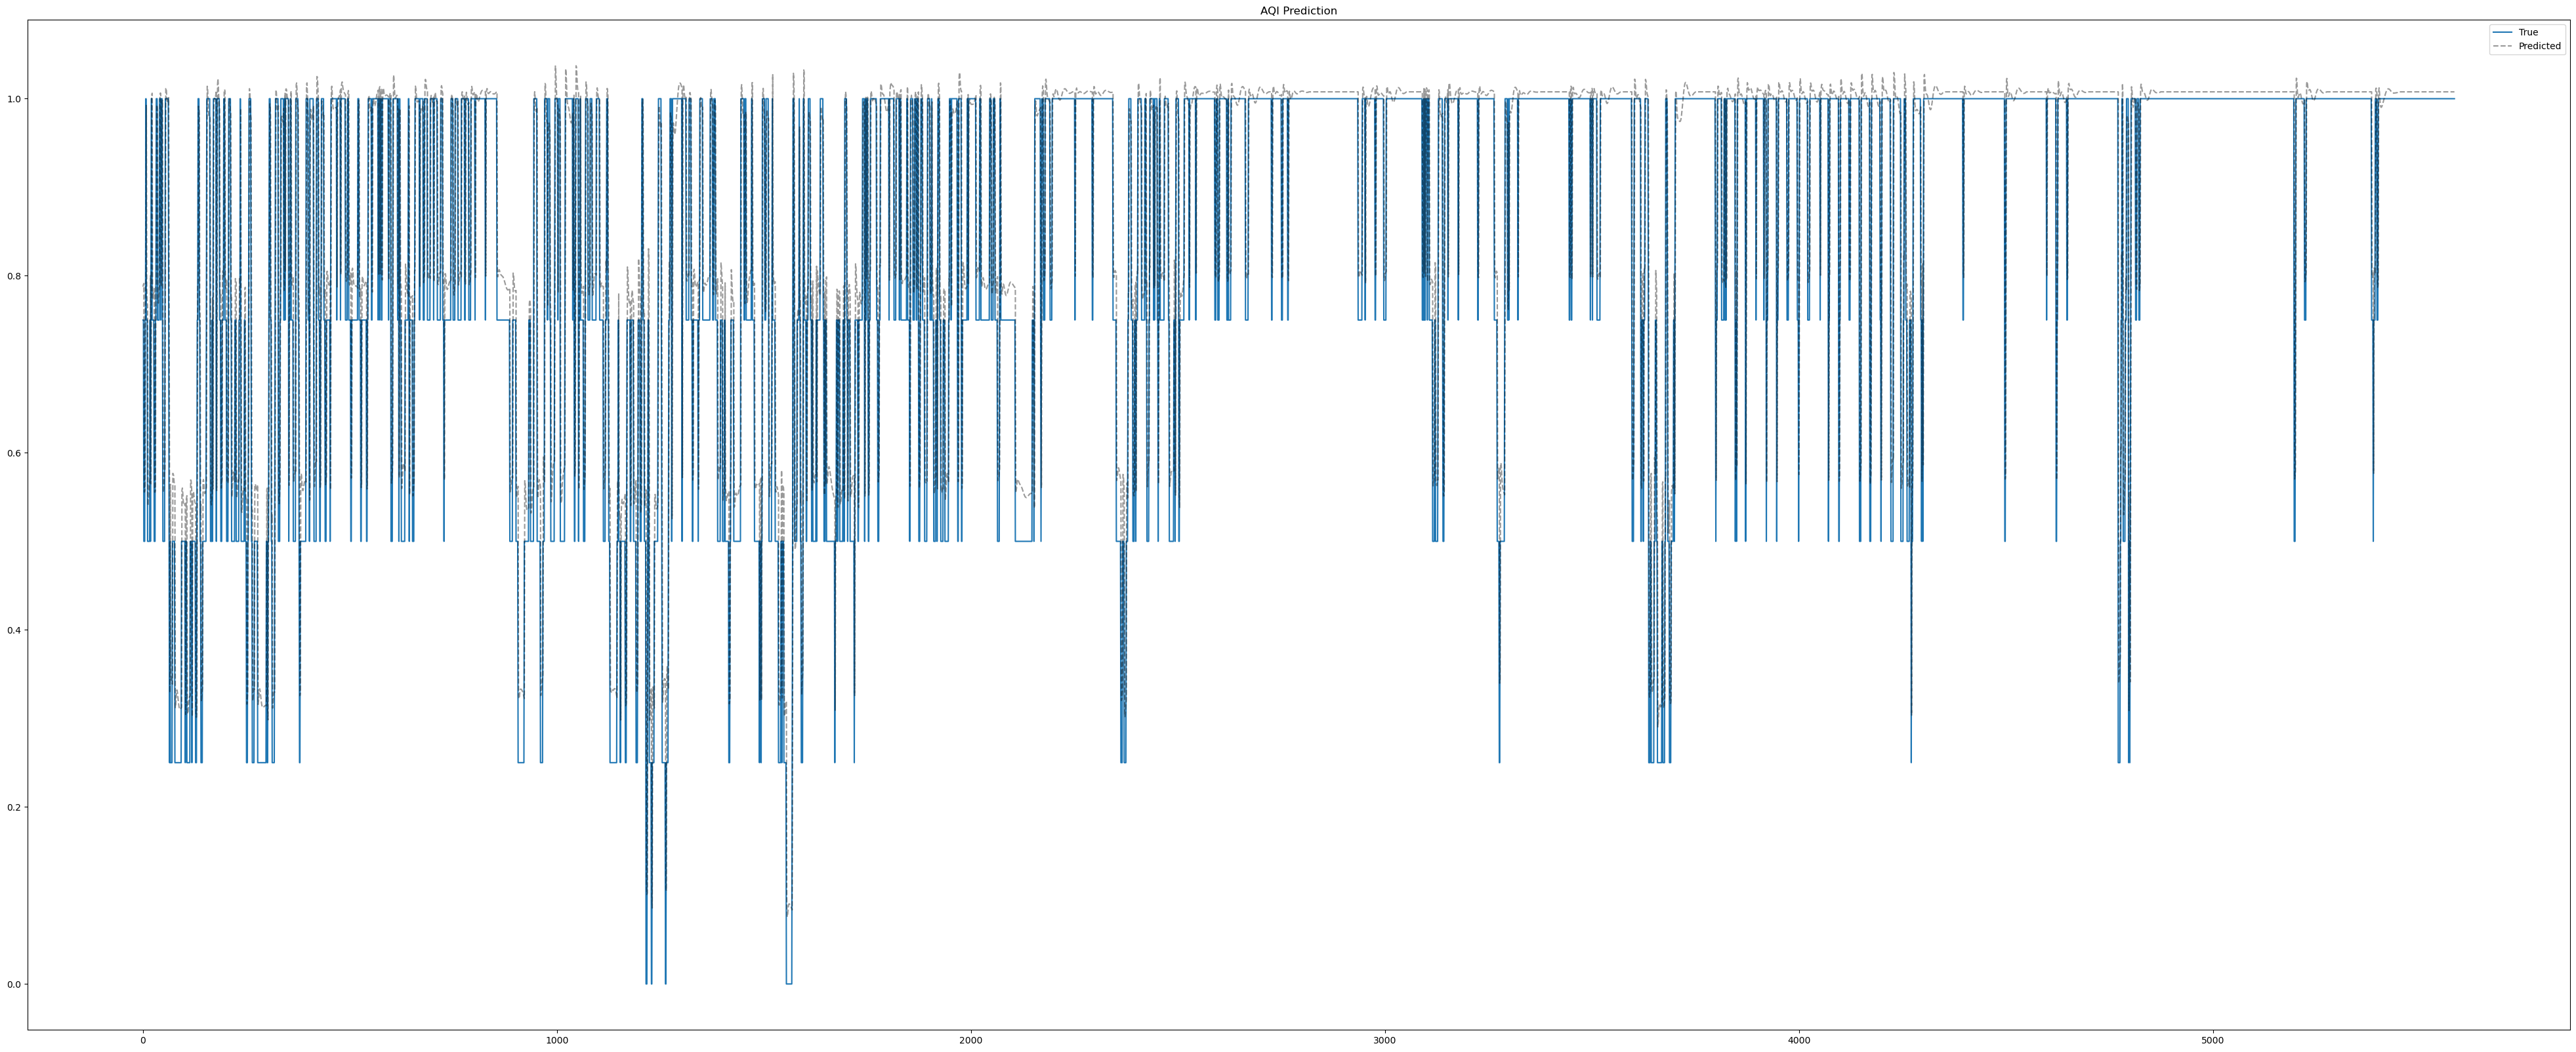

In [12]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt

rmse = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse}")

mse = mean_squared_error(y_test, y_pred)
print(f"MSE: {mse}")

plt.figure(figsize=(50, 20))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted', color='black', alpha=0.4, linestyle='dashed')
plt.title("AQI Prediction")
plt.legend()
plt.show()

In [14]:
## Train loss
loaded_model.evaluate(X_train, y_train)

698/698 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0064 - mae: 0.0361


[0.007779892534017563, 0.042367562651634216]